In [1]:
import os
import pickle
import copy
import random
import logging
import argparse
import pandas

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from collections import defaultdict

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from timeit import default_timer as timer
from datetime import timedelta

from blocks import VAE
from dataset import MorphologyDatasetTask3, Vocabulary

from blocks_main import initialize_model, initialize_dataloader

import main

In [2]:
def plot_TSNE(z_list, l_list=None, hide_axis=True, pca_components=50, num_clusters=10, unique_keys=None):
    
    if pca_components is not None:
        pca    = PCA(n_components=pca_components)
        z_list = pca.fit_transform(z_list)

    X_reduced = TSNE(n_components=2, random_state=0).fit_transform(z_list)

    with plt.style.context('seaborn-deep'):
        plt.figure(figsize=(8, 6))

        fig, ax = plt.subplots()
        cax = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=l_list[:], marker='o', edgecolor='none', 
                         cmap=plt.cm.get_cmap('tab20', num_clusters), alpha=1)
        cbar = fig.colorbar(cax, ticks=list(range(len(unique_keys))))
        cbar.ax.set_yticklabels(unique_keys)

        axes = plt.gca()
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)

        plt.show()

### Word VAE 

In [3]:
def get_z_VAE(model, test_loader):

    model.eval()
    z_list = None
    it_sup = iter(test_loader)
    i      = 0

    while True:
        try:
            sample_batched_sup = next(it_sup)
        except StopIteration:
            break

        x_t_sup = sample_batched_sup['target_form'].to(device)
        x_t_sup = torch.transpose(x_t_sup, 0, 1)

        outputs, mu, logvar = model(x_t_sup)

        z = model.reparameterize(mu, logvar)
        
        if i == 0:
            z_list = z.detach().cpu().numpy()
        else:
            z_list = np.concatenate((z_list, z.detach().cpu().numpy()), axis=0)
        
        i += 1
        
        if i == 10000:
            break

    print("Num test points = {}".format(str(i)))
    return z_list

In [4]:
language = 'turkish'
model_id = '6'

device         = torch.device('cpu')
checkpoint     = torch.load('../models/vae_{}-{}/model.pt'.format(language, model_id), map_location=device)

config         = checkpoint['config']
vocab          = checkpoint['vocab']

test_loader, d = initialize_dataloader(run_type='train', language=config['language'], task='sup',
                                       vocab=vocab, batch_size=1, shuffle=True)
idx_2_char     = d.idx_2_char

model          = initialize_model(config)
model.load_state_dict(checkpoint['model_state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Num test points = 10000


TypeError: 'NoneType' object is not subscriptable

<Figure size 576x432 with 0 Axes>

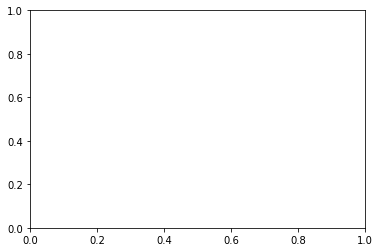

In [5]:
z_list = get_z_VAE(model, test_loader)

plot_TSNE(z_list, hide_axis=False)

### Labeled MSVAE

In [ ]:
def get_z_MSVAE(model, test_loader, unique_keys, idx_2_char):

    model.eval()
    z_list = None
    l_list = []
    it_sup = iter(test_loader)
    i      = 0

    while True:
        try:
            sample_batched_sup = next(it_sup)
        except StopIteration:
            break

        x_t_sup = sample_batched_sup['target_form'].to(device)
        y_t_sup = sample_batched_sup['msd'].to(device)

        x_t_sup = torch.transpose(x_t_sup, 0, 1)
        y_t_sup = torch.transpose(y_t_sup, 0, 1)

        outputs, mu, logvar = model(x_t_sup, y_t_sup)
#         z                   = model.reparameterize(mu, logvar)
        z = mu
        
        if i == 0:
            z_list = z.detach().cpu().numpy()
        else:
            z_list = np.concatenate((z_list, z.detach().cpu().numpy()), axis=0)
            
        print(outputs.size())

        outputs     = outputs[1:].view(-1, outputs.shape[-1])
        outputs     = F.log_softmax(outputs, dim=1).type(torch.LongTensor)
        outputs     = torch.squeeze(outputs, 1)
        print(outputs.size())
        
        target_word = ''
        for j in outputs:
            p      = np.argmax(j, axis=0).detach().cpu().item()
            entity = idx_2_char[p]

            if   entity == '<SOS>':
                continue
            elif entity == '<PAD>' or entity == '<EOS>':
                break

            target_word += idx_2_char[p]

        print('actual: {}, predicted: {}'.format(sample_batched_sup['target_str'][0], target_word))

        x_s_raw = sample_batched_sup['source_str'][0]
        label   = unique_keys.index(x_s_raw)
        l_list.append(label)
        i += 1
        
#         if i == 100:
#             break

    print("Num test points = {}".format(str(i)))
    return z_list, l_list

In [ ]:
language = 'turkish'
model_id = '5'

device         = torch.device('cpu')
checkpoint     = torch.load('../models/vae_{}-{}/model.pt'.format(language, model_id), map_location=device)

config         = checkpoint['config']
vocab          = checkpoint['vocab']

max_seq_len    = main.get_max_seq_len(language, vocab)
csvpath        = '../data/{}_stem_greater_12'.format(language)
d              = MorphologyDatasetTask3(test=True, language=language, vocab=vocab, tasks=['none'], get_unprocessed=True,
                                        max_unsup=10000, max_seq_len=max_seq_len, csvpath=csvpath)
test_loader    = DataLoader(d, batch_size=1, shuffle=False, num_workers=2)


idx_2_char     = d.idx_2_char

model          = initialize_model(config)
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
with open(csvpath, 'r') as f:
    source = f.read()

lines = source.strip().split('\n')

print('Total lines: {}'.format(len(lines)))

unique_x_s = defaultdict(int)
unique_msd = defaultdict(int)

for line in lines:
    words = line.strip().split('\t')
    msds  = words[1].strip().split(',')

    unique_x_s[words[0]] += 1

    for msd in msds:
        unique_msd[msd]  += 1

In [ ]:
unique_keys = list(unique_x_s.keys())
z_list, l_list = get_z_MSVAE(model, test_loader, unique_keys, idx_2_char)

In [ ]:
unique_keys = list(unique_x_s.keys())

ticks = []

for i in range(len(set(l_list))):
    ticks.append(unique_keys[i])

plot_TSNE(z_list, l_list, num_clusters=len(set(l_list)), pca_components=None, unique_keys=unique_keys)

In [ ]:
language = 'turkish'
model_id = 1

### Rectified random variables

In [ ]:
unique_keys = list(unique_x_s.keys())

In [14]:
def get_z_Ours(model_id, language, unique_keys, csvpath):

    device         = torch.device('cpu')
    checkpoint     = torch.load('../models/{}-{}/model.pt'.format(language, model_id), map_location=device)

    config         = checkpoint['config']
    vocab          = checkpoint['vocab']

    max_seq_len    = main.get_max_seq_len(language, vocab)
    d              = MorphologyDatasetTask3(test=True, language=language, vocab=vocab, tasks=['none'], get_unprocessed=True,
                                            max_unsup=10000, max_seq_len=max_seq_len, csvpath=csvpath)
    test_loader    = DataLoader(d, batch_size=1, shuffle=False, num_workers=2)


    idx_2_char     = d.idx_2_char

    model, _       = main.initialize_model(config)

    model.load_state_dict(checkpoint['model_state_dict'])

    model.eval()
    z_list = None
    l_list = []
    it_sup = iter(test_loader)
    i      = 0
    correct= 0

    while True:
        try:
            sample_batched_sup = next(it_sup)
        except StopIteration:
            break
        
        x_s_sup = sample_batched_sup['source_form'].to(device)
        x_t_sup = sample_batched_sup['target_form'].to(device)
        y_t_sup = sample_batched_sup['msd'].to(device)

        x_s_sup = torch.transpose(x_s_sup, 0, 1)
        x_t_sup = torch.transpose(x_t_sup, 0, 1)
        y_t_sup = torch.transpose(y_t_sup, 0, 1)

        outputs, mu, logvar = model(x_s_sup, x_t_sup, y_t_sup)
        z = mu
        
        if i == 0:
            z_list = z.detach().cpu().numpy()
        else:
            z_list = np.concatenate((z_list, z.detach().cpu().numpy()), axis=0)
            
        outputs     = outputs[1:].view(-1, outputs.shape[-1])
        outputs     = F.log_softmax(outputs, dim=1).type(torch.LongTensor)
        outputs     = torch.squeeze(outputs, 1)
        
        target_word = ''
        for j in outputs:
            p      = np.argmax(j, axis=0).detach().cpu().item()
            entity = idx_2_char[p]

            if   entity == '<SOS>':
                continue
            elif entity == '<PAD>' or entity == '<EOS>':
                break

            target_word += idx_2_char[p]

        # print('actual: {}, predicted: {}'.format(sample_batched_sup['target_str'][0], target_word))
        if sample_batched_sup['target_str'][0] == target_word:
            correct += 1

        x_s_raw = sample_batched_sup['source_str'][0]
        label   = unique_keys.index(x_s_raw)
        l_list.append(label)
        i += 1

    print("Num test points = {}".format(str(i)))
    print("Accuracy = {}".format((correct * 1.) / i))
    return z_list, l_list

In [6]:
language = 'turkish'
csvpath  = '../data/{}_stem_greater_12'.format(language)

with open(csvpath, 'r') as f:
    source = f.read()

lines = source.strip().split('\n')

print('Total lines: {}'.format(len(lines)))

unique_x_s = defaultdict(int)
unique_msd = defaultdict(int)

for line in lines:
    words = line.strip().split('\t')
    msds  = words[1].strip().split(',')

    unique_x_s[words[0]] += 1

    for msd in msds:
        unique_msd[msd]  += 1

unique_keys = list(unique_x_s.keys())

Total lines: 203


In [98]:
model_id = '19'

z_list_19, l_list_19 = get_z_Ours(model_id, language, unique_keys, csvpath)

Num test points = 203
Accuracy = 0.6847290640394089


<Figure size 576x432 with 0 Axes>

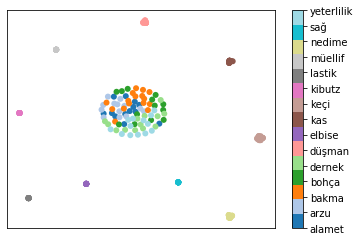

In [99]:
ticks = []

for i in range(len(set(l_list_19))):
    ticks.append(unique_keys[i])

plot_TSNE(z_list_19, l_list_19, num_clusters=len(set(l_list_19)), pca_components=None, unique_keys=unique_keys)

In [100]:
model_id = '24'

z_list_20, l_list_20 = get_z_Ours(model_id, language, unique_keys, csvpath)

Num test points = 203
Accuracy = 0.6551724137931034


<Figure size 576x432 with 0 Axes>

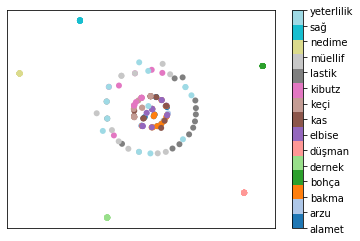

In [101]:
ticks = []

for i in range(len(set(l_list_20))):
    ticks.append(unique_keys[i])

plot_TSNE(z_list_20, l_list_19, num_clusters=len(set(l_list_19)), pca_components=None, unique_keys=unique_keys)

In [102]:
X_reduced_19 = TSNE(n_components=2, random_state=0).fit_transform(z_list_19)
X_reduced_20 = TSNE(n_components=2, random_state=0).fit_transform(z_list_20)

num_clusters=len(set(l_list_19))

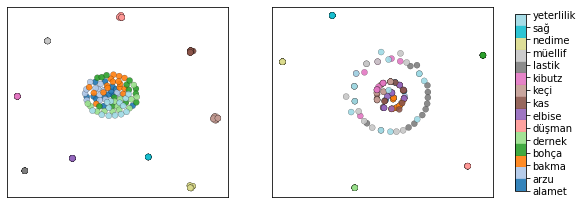

In [103]:
X_reduced = X_reduced_19
l_list = l_list_19

with plt.style.context('seaborn-deep'):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))

    for ax in axes.flat:
        im = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=l_list[:], marker='o', edgecolor='black', linewidths=0.2, 
                        cmap=plt.cm.get_cmap('tab20', num_clusters), alpha=0.9)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)

        X_reduced = X_reduced_20
        l_list = l_list_20

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.83, 0.15, 0.015, 0.7])

    cbar = fig.colorbar(im, cax=cbar_ax, ticks=list(range(len(unique_keys))))
    cbar.ax.set_yticklabels(unique_keys)
    
    plt.show()